# ETF Data Validation Dashboard

This notebook validates the quality and completeness of the ETF data we've collected.

**Note:** Run this notebook from the project root (`/home/stuar/code/ETFTrader`) using `jupyter lab`

## Contents:
1. ETF Universe Overview
2. Price Data Quality Check
3. Missing Data Analysis
4. Data Coverage Visualization
5. Fundamental Data Review
6. Sample Price Data Exploration
7. Summary & Next Steps

In [6]:
# Import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Find project root by looking for marker files
current_path = Path.cwd().resolve()
project_root = current_path

# Search up the directory tree for project root
while project_root != project_root.parent:
    if (project_root / 'src' / 'data_collection').exists() or (project_root / 'requirements.txt').exists():
        break
    project_root = project_root.parent

# Ensure project root is in path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import project modules
from src.data_collection.data_validator import DataValidator

# Define data paths (absolute)
DATA_ROOT = project_root / 'data'
UNIVERSE_FILE = DATA_ROOT / 'raw' / 'etf_universe.csv'
PRICES_DIR = DATA_ROOT / 'raw' / 'prices'
FUNDAMENTALS_FILE = DATA_ROOT / 'raw' / 'fundamentals.csv'

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print(f"✅ Libraries imported successfully")
print(f"📂 Project root: {project_root}")
print(f"📂 Current directory: {current_path}")

✅ Libraries imported successfully
📂 Project root: /home/stuar/code/ETFTrader
📂 Current directory: /home/stuar/code/ETFTrader/notebooks


## 1. ETF Universe Overview

In [7]:
# Load ETF universe
universe = pd.read_csv(UNIVERSE_FILE)

print(f"Total ETFs in Universe: {len(universe)}")
print(f"\nDataset shape: {universe.shape}")

# Display sample
print("\nSample ETFs:")
universe.head(10)

Total ETFs in Universe: 298

Dataset shape: (298, 10)

Sample ETFs:


,ticker,name,category,expense_ratio,aum,inception_date,exchange,currency,is_leveraged,data_collection_date
0,SPY,SPDR S&P 500 ETF,Large Blend,NaN,6.727266e+11,7.276608e+08,PCX,USD,False,2025-10-04
1,IVV,iShares Core S&P 500 ETF,Large Blend,NaN,7.013694e+11,9.583488e+08,PCX,USD,False,2025-10-04
2,VOO,Vanguard S&P 500 ETF,Large Blend,NaN,1.399421e+12,9.740736e+08,PCX,USD,False,2025-10-04
3,QQQ,Invesco QQQ Trust,Large Growth,NaN,3.857552e+11,9.210240e+08,NGM,USD,False,2025-10-04
4,VTI,Vanguard Total Stock Market Index Fund ETF Shares,Large Blend,NaN,1.973047e+12,9.740736e+08,PCX,USD,False,2025-10-04
5,VEA,Vanguard FTSE Developed Markets Index Fund ETF...,Foreign Large Blend,NaN,2.485745e+11,9.785664e+08,PCX,USD,False,2025-10-04
6,IEFA,iShares Core MSCI EAFE ETF,Foreign Large Blend,NaN,1.555237e+11,1.350518e+09,BTS,USD,False,2025-10-04
7,AGG,iShares Core U.S. Aggregate Bond ETF,Intermediate Core Bond,NaN,1.318272e+11,1.064189e+09,PCX,USD,False,2025-10-04
8,BND,Vanguard Total Bond Market Index Fund,Intermediate Core Bond,NaN,3.706181e+11,1.005523e+09,NGM,USD,False,2025-10-04
9,VWO,Vanguard Emerging Markets Stock Index Fund,Diversified Emerging Mkts,NaN,1.364082e+11,1.151021e+09,PCX,USD,False,2025-10-04


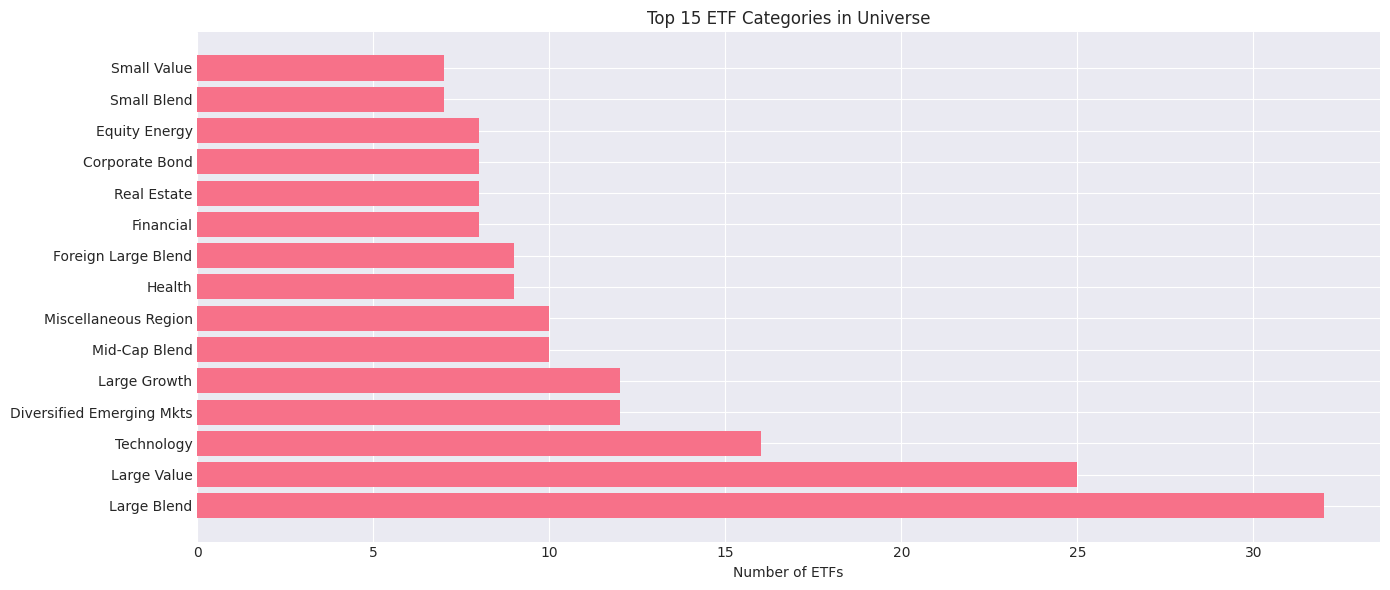


Total Categories: 60


In [8]:
# Category distribution
plt.figure(figsize=(14, 6))

category_counts = universe['category'].value_counts().head(15)
plt.barh(range(len(category_counts)), category_counts.values)
plt.yticks(range(len(category_counts)), category_counts.index)
plt.xlabel('Number of ETFs')
plt.title('Top 15 ETF Categories in Universe')
plt.tight_layout()
plt.show()

print(f"\nTotal Categories: {universe['category'].nunique()}")

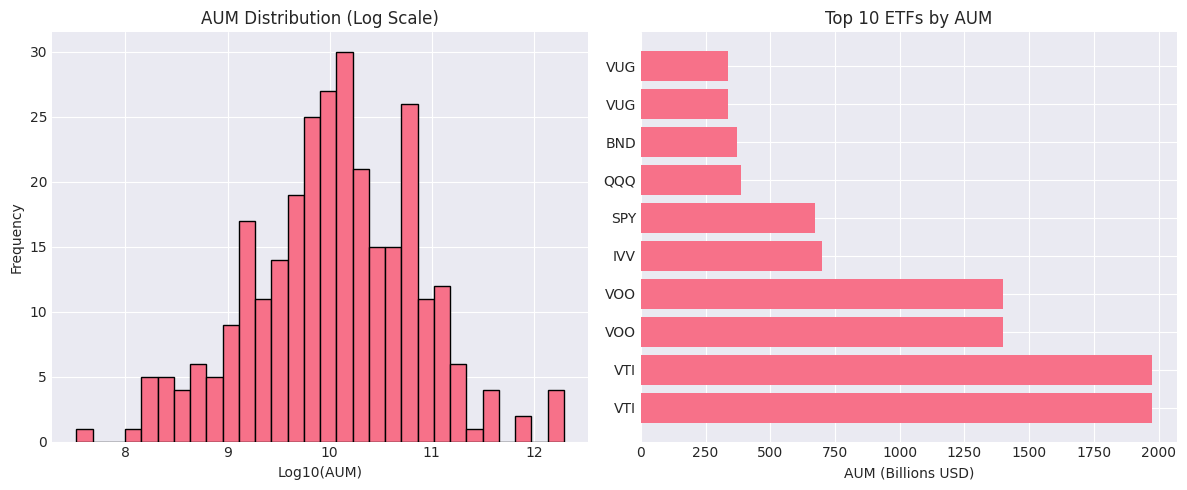


AUM Statistics (in Billions):
Mean: $59.18B
Median: $11.52B
Min: $0.03B
Max: $1973.05B


In [9]:
# AUM distribution
plt.figure(figsize=(12, 5))

# Filter out NaN values
aum_data = universe['aum'].dropna()

if len(aum_data) > 0:
    plt.subplot(1, 2, 1)
    plt.hist(np.log10(aum_data), bins=30, edgecolor='black')
    plt.xlabel('Log10(AUM)')
    plt.ylabel('Frequency')
    plt.title('AUM Distribution (Log Scale)')

    plt.subplot(1, 2, 2)
    top_10_aum = universe.nlargest(10, 'aum')[['ticker', 'name', 'aum']]
    plt.barh(range(len(top_10_aum)), top_10_aum['aum'].values / 1e9)
    plt.yticks(range(len(top_10_aum)), top_10_aum['ticker'].values)
    plt.xlabel('AUM (Billions USD)')
    plt.title('Top 10 ETFs by AUM')

    plt.tight_layout()
    plt.show()

    print(f"\nAUM Statistics (in Billions):")
    print(f"Mean: ${aum_data.mean()/1e9:.2f}B")
    print(f"Median: ${aum_data.median()/1e9:.2f}B")
    print(f"Min: ${aum_data.min()/1e9:.2f}B")
    print(f"Max: ${aum_data.max()/1e9:.2f}B")
else:
    print("No AUM data available")

## 2. Price Data Quality Check

In [10]:
# Run data validator with absolute paths
validator = DataValidator(
    prices_dir=str(PRICES_DIR),
    fundamentals_file=str(FUNDAMENTALS_FILE)
)
validation_results = validator.validate_universe(str(UNIVERSE_FILE))

print("\nValidation Results (first 10):")
validation_results.head(10)

Data Validation Report

Validating 298 ETFs...
  [1/298] Validating SPY...
  [2/298] Validating IVV...
  [3/298] Validating VOO...
  [4/298] Validating QQQ...
  [5/298] Validating VTI...
  [6/298] Validating VEA...
  [7/298] Validating IEFA...
  [8/298] Validating AGG...
  [9/298] Validating BND...
  [10/298] Validating VWO...
  [11/298] Validating VTV...
  [12/298] Validating VUG...
  [13/298] Validating IWF...
  [14/298] Validating IWM...
  [15/298] Validating IJH...
  [16/298] Validating VIG...
  [17/298] Validating SCHD...
  [18/298] Validating VNQ...
  [19/298] Validating VNQI...
  [20/298] Validating GLD...
  [21/298] Validating SLV...
  [22/298] Validating DIA...
  [23/298] Validating EEM...
  [24/298] Validating EFA...
  [25/298] Validating HYG...
  [26/298] Validating LQD...
  [27/298] Validating TLT...
  [28/298] Validating IEF...
  [29/298] Validating SHY...
  [30/298] Validating MUB...
  [31/298] Validating VGT...
  [32/298] Validating XLK...
  [33/298] Validating XLF...
  

,ticker,status,num_rows,start_date,end_date,date_range_days,missing_dates,missing_pct,null_values,zero_volume_days,duplicate_dates,extreme_changes,negative_prices,issues,avg_volume,avg_price,error
0,SPY,OK,753.0,2022-10-04 04:00:00+00:00,2025-10-03 04:00:00+00:00,1095.0,31.0,3.95,0.0,0.0,0.0,0.0,0.0,none,7.114981e+07,496.670576,NaN
1,IVV,OK,753.0,2022-10-04 04:00:00+00:00,2025-10-03 04:00:00+00:00,1095.0,31.0,3.95,0.0,0.0,0.0,0.0,0.0,none,5.273415e+06,498.492190,NaN
2,VOO,OK,753.0,2022-10-04 04:00:00+00:00,2025-10-03 04:00:00+00:00,1095.0,31.0,3.95,0.0,0.0,0.0,0.0,0.0,none,5.362450e+06,456.094274,NaN
3,QQQ,OK,753.0,2022-10-04 04:00:00+00:00,2025-10-03 04:00:00+00:00,1095.0,31.0,3.95,0.0,0.0,0.0,0.0,0.0,none,4.605577e+07,422.229462,NaN
4,VTI,OK,753.0,2022-10-04 04:00:00+00:00,2025-10-03 04:00:00+00:00,1095.0,31.0,3.95,0.0,0.0,0.0,0.0,0.0,none,3.343189e+06,245.886033,NaN
5,VEA,OK,753.0,2022-10-04 04:00:00+00:00,2025-10-03 04:00:00+00:00,1095.0,31.0,3.95,0.0,0.0,0.0,0.0,0.0,none,1.146977e+07,46.548076,NaN
6,IEFA,OK,753.0,2022-10-04 04:00:00+00:00,2025-10-03 04:00:00+00:00,1095.0,31.0,3.95,0.0,0.0,0.0,0.0,0.0,none,9.407255e+06,68.445254,NaN
7,AGG,OK,753.0,2022-10-04 04:00:00+00:00,2025-10-03 04:00:00+00:00,1095.0,31.0,3.95,0.0,0.0,0.0,0.0,0.0,none,8.163654e+06,92.459228,NaN
8,BND,OK,753.0,2022-10-04 04:00:00+00:00,2025-10-03 04:00:00+00:00,1095.0,31.0,3.95,0.0,0.0,0.0,0.0,0.0,none,6.467112e+06,68.617756,NaN
9,VWO,OK,753.0,2022-10-04 04:00:00+00:00,2025-10-03 04:00:00+00:00,1095.0,31.0,3.95,0.0,0.0,0.0,0.0,0.0,none,9.902338e+06,41.421969,NaN


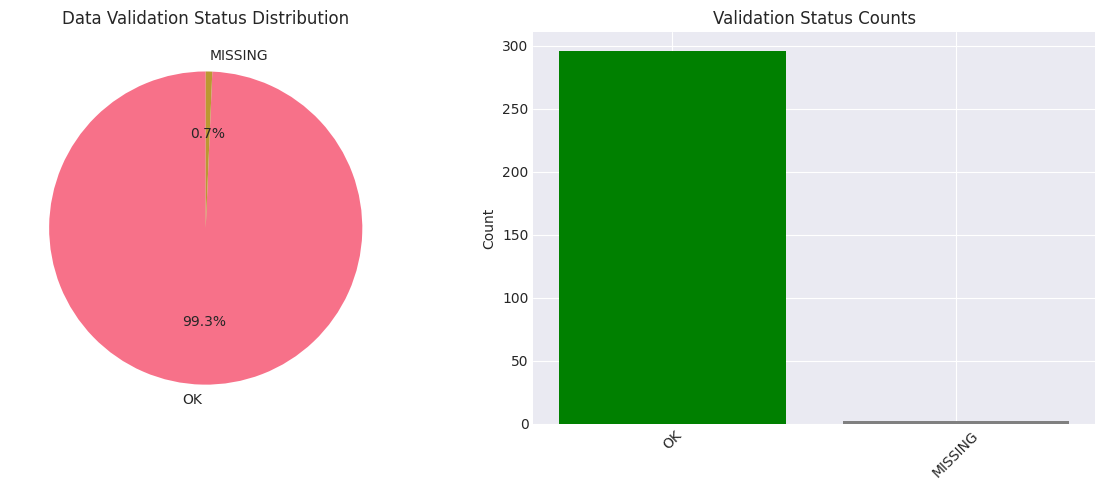

In [11]:
# Status distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
status_counts = validation_results['status'].value_counts()
plt.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Data Validation Status Distribution')

plt.subplot(1, 2, 2)
colors = {'OK': 'green', 'WARNING': 'orange', 'CRITICAL': 'red', 'MISSING': 'gray', 'ERROR': 'purple'}
bars = plt.bar(range(len(status_counts)), status_counts.values,
               color=[colors.get(x, 'blue') for x in status_counts.index])
plt.xticks(range(len(status_counts)), status_counts.index, rotation=45)
plt.ylabel('Count')
plt.title('Validation Status Counts')

plt.tight_layout()
plt.show()

In [12]:
# Calculate quality score
quality_score = validator.get_quality_score(validation_results)

print(f"\n{'='*60}")
print(f"Overall Data Quality Score: {quality_score}/100")
print(f"{'='*60}")

if quality_score >= 90:
    print("✅ EXCELLENT - Data is ready for production use")
elif quality_score >= 75:
    print("✅ GOOD - Data is acceptable with minor issues")
elif quality_score >= 60:
    print("⚠️  ACCEPTABLE - Some data quality concerns")
else:
    print("❌ POOR - Significant data quality issues need attention")


Overall Data Quality Score: 93.8/100
✅ EXCELLENT - Data is ready for production use


## 3. Missing Data Analysis

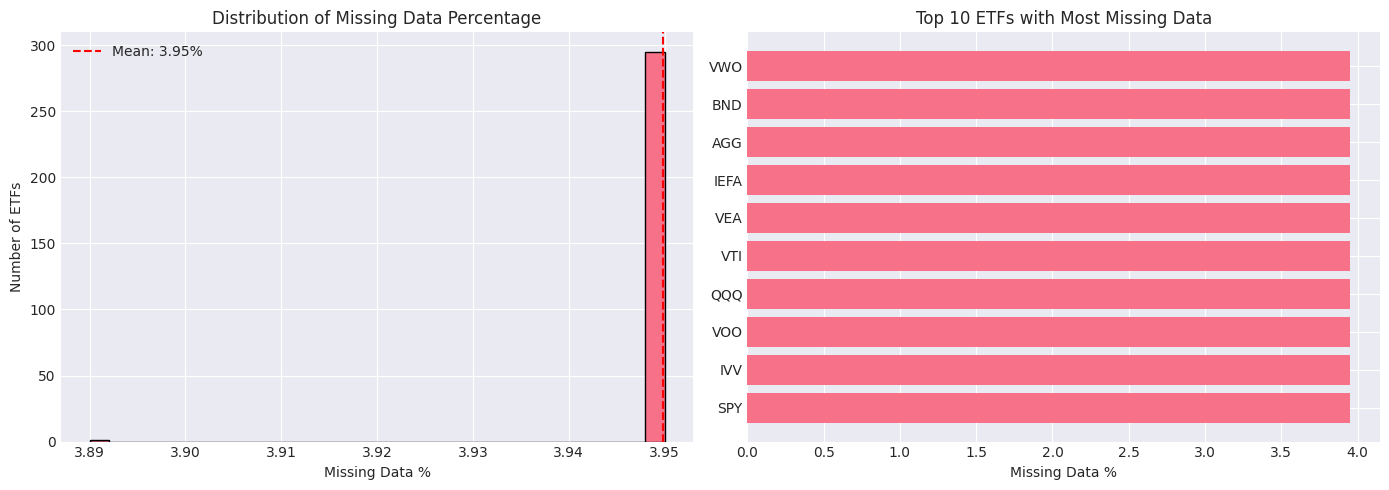


Missing Data Statistics:
Average: 3.95%
Median: 3.95%
Max: 3.95%


In [13]:
# Filter for successful validations
valid_data = validation_results[validation_results['status'].isin(['OK', 'WARNING'])]

if len(valid_data) > 0 and 'missing_pct' in valid_data.columns:
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.hist(valid_data['missing_pct'], bins=30, edgecolor='black')
    plt.xlabel('Missing Data %')
    plt.ylabel('Number of ETFs')
    plt.title('Distribution of Missing Data Percentage')
    plt.axvline(valid_data['missing_pct'].mean(), color='red', linestyle='--',
                label=f'Mean: {valid_data["missing_pct"].mean():.2f}%')
    plt.legend()

    plt.subplot(1, 2, 2)
    # Top 10 ETFs with most missing data
    top_missing = valid_data.nlargest(10, 'missing_pct')[['ticker', 'missing_pct']]
    plt.barh(range(len(top_missing)), top_missing['missing_pct'].values)
    plt.yticks(range(len(top_missing)), top_missing['ticker'].values)
    plt.xlabel('Missing Data %')
    plt.title('Top 10 ETFs with Most Missing Data')

    plt.tight_layout()
    plt.show()

    print(f"\nMissing Data Statistics:")
    print(f"Average: {valid_data['missing_pct'].mean():.2f}%")
    print(f"Median: {valid_data['missing_pct'].median():.2f}%")
    print(f"Max: {valid_data['missing_pct'].max():.2f}%")
else:
    print("No valid data to analyze missing percentages")

## 4. Data Coverage Visualization

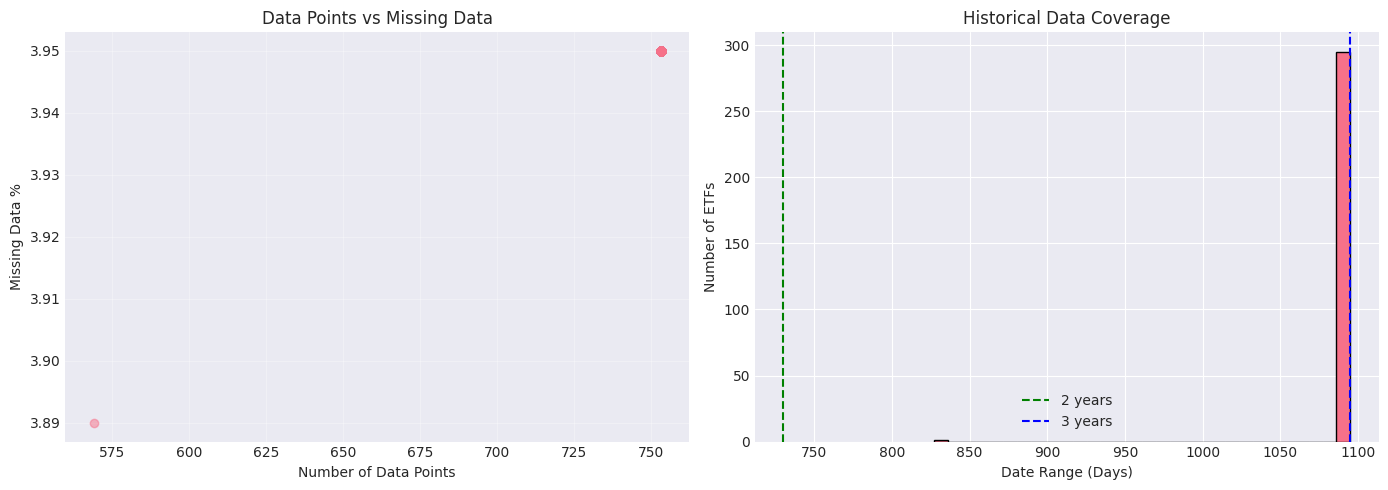


Data Coverage Statistics:
Average rows per ETF: 752
Average date range: 1094 days (3.0 years)

Coverage Summary:
ETFs with 2+ years: 296 (100.0%)
ETFs with 3+ years: 295 (99.7%)


In [14]:
if len(valid_data) > 0 and 'num_rows' in valid_data.columns:
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(valid_data['num_rows'], valid_data['missing_pct'], alpha=0.5)
    plt.xlabel('Number of Data Points')
    plt.ylabel('Missing Data %')
    plt.title('Data Points vs Missing Data')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(valid_data['date_range_days'], bins=30, edgecolor='black')
    plt.xlabel('Date Range (Days)')
    plt.ylabel('Number of ETFs')
    plt.title('Historical Data Coverage')
    plt.axvline(730, color='green', linestyle='--', label='2 years')
    plt.axvline(1095, color='blue', linestyle='--', label='3 years')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nData Coverage Statistics:")
    print(f"Average rows per ETF: {valid_data['num_rows'].mean():.0f}")
    print(f"Average date range: {valid_data['date_range_days'].mean():.0f} days ({valid_data['date_range_days'].mean()/365:.1f} years)")

    # ETFs with 2+ years of data
    two_year_coverage = (valid_data['date_range_days'] >= 730).sum()
    three_year_coverage = (valid_data['date_range_days'] >= 1095).sum()

    print(f"\nCoverage Summary:")
    print(f"ETFs with 2+ years: {two_year_coverage} ({two_year_coverage/len(valid_data)*100:.1f}%)")
    print(f"ETFs with 3+ years: {three_year_coverage} ({three_year_coverage/len(valid_data)*100:.1f}%)")
else:
    print("No valid data to analyze coverage")

## 5. Fundamental Data Review

In [15]:
# Load fundamentals
fundamentals = pd.read_csv(FUNDAMENTALS_FILE)

print(f"Total ETFs with fundamental data: {len(fundamentals)}")
print(f"\nFundamental Data Sample:")
fundamentals.head(10)

Total ETFs with fundamental data: 296

Fundamental Data Sample:


,ticker,name,category,expense_ratio,aum,ytd_return,inception_date,exchange,currency
0,SPY,SPDR S&P 500 ETF,Large Blend,NaN,672726646784,14.74103,727660800,PCX,USD
1,IVV,iShares Core S&P 500 ETF,Large Blend,NaN,701369352192,14.81177,958348800,PCX,USD
2,VOO,Vanguard S&P 500 ETF,Large Blend,NaN,1399420616704,14.80406,974073600,PCX,USD
3,QQQ,Invesco QQQ Trust,Large Growth,NaN,385755185152,17.91539,921024000,NGM,USD
4,VTI,Vanguard Total Stock Market Index Fund ETF Shares,Large Blend,NaN,1973047394304,14.34394,974073600,PCX,USD
5,VEA,Vanguard FTSE Developed Markets Index Fund ETF...,Foreign Large Blend,NaN,248574509056,27.84040,978566400,PCX,USD
6,IEFA,iShares Core MSCI EAFE ETF,Foreign Large Blend,NaN,155523727360,26.60728,1350518400,BTS,USD
7,AGG,iShares Core U.S. Aggregate Bond ETF,Intermediate Core Bond,NaN,131827171328,6.12732,1064188800,PCX,USD
8,BND,Vanguard Total Bond Market Index Fund,Intermediate Core Bond,NaN,370618138624,6.10040,1005523200,NGM,USD
9,VWO,Vanguard Emerging Markets Stock Index Fund,Diversified Emerging Mkts,NaN,136408219648,23.14876,1151020800,PCX,USD


In [16]:
# Expense ratio distribution
expense_data = fundamentals['expense_ratio'].dropna()

if len(expense_data) > 0:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(expense_data, bins=30, edgecolor='black')
    plt.xlabel('Expense Ratio')
    plt.ylabel('Number of ETFs')
    plt.title('Expense Ratio Distribution')
    plt.axvline(0.01, color='green', linestyle='--', label='1% threshold')
    plt.legend()

    plt.subplot(1, 2, 2)
    # Top 10 lowest expense ratios
    top_low_expense = fundamentals.nsmallest(10, 'expense_ratio')[['ticker', 'name', 'expense_ratio']]
    plt.barh(range(len(top_low_expense)), top_low_expense['expense_ratio'].values)
    plt.yticks(range(len(top_low_expense)), top_low_expense['ticker'].values)
    plt.xlabel('Expense Ratio')
    plt.title('Top 10 Lowest Expense Ratio ETFs')

    plt.tight_layout()
    plt.show()

    print(f"\nExpense Ratio Statistics:")
    print(f"Mean: {expense_data.mean():.4f} ({expense_data.mean()*100:.2f}%)")
    print(f"Median: {expense_data.median():.4f} ({expense_data.median()*100:.2f}%)")
    print(f"Min: {expense_data.min():.4f} ({expense_data.min()*100:.2f}%)")
    print(f"Max: {expense_data.max():.4f} ({expense_data.max()*100:.2f}%)")
else:
    print("No expense ratio data available")

No expense ratio data available


## 6. Sample Price Data Exploration

Sample ETF: SPY
Data points: 753
Date range: 2022-10-04 00:00:00-04:00 to 2025-10-03 00:00:00-04:00


/tmp/ipykernel_99579/821406206.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  spy_data['date'] = pd.to_datetime(spy_data['date'])


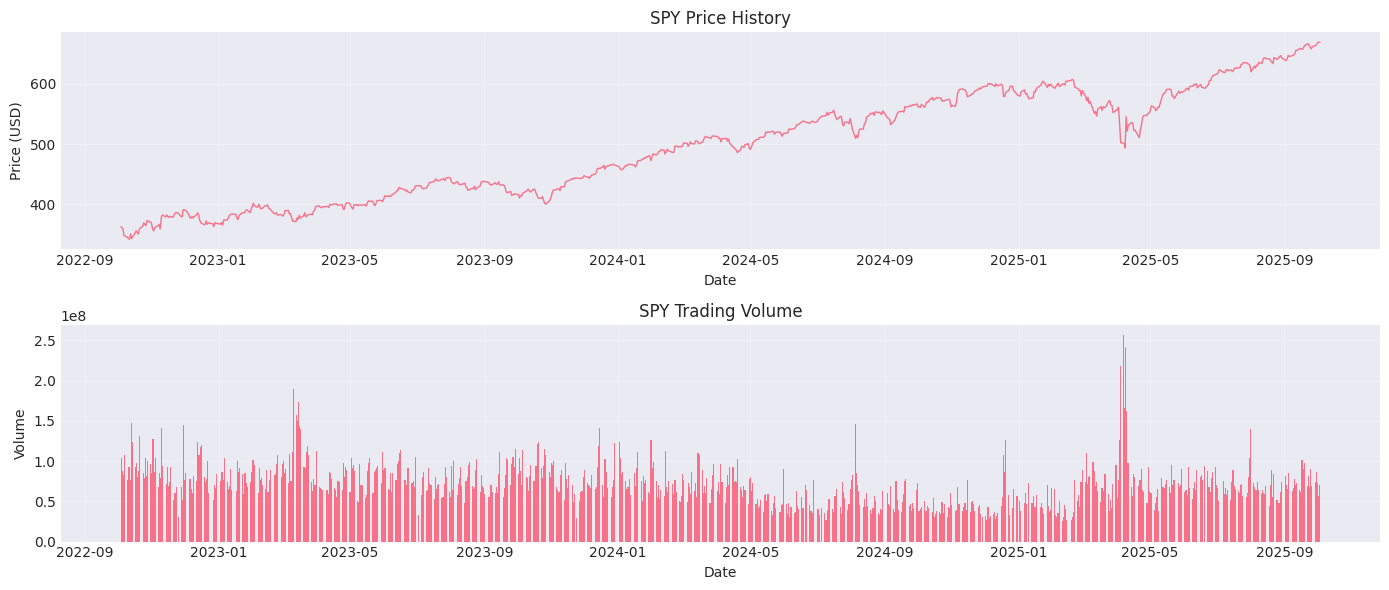


Sample Data (first 5 rows):
                        date        open        high         low       close  \
0  2022-10-04 00:00:00-04:00  357.391836  362.766156  351.796805  362.737366   
1  2022-10-05 00:00:00-04:00  358.341984  364.167334  356.000317  361.892853   
2  2022-10-06 00:00:00-04:00  360.482092  363.457165  357.660575  358.159637   
3  2022-10-07 00:00:00-04:00  354.100091  358.245997  346.393710  348.169159   
4  2022-10-10 00:00:00-04:00  349.291927  349.531852  343.255443  345.510712   

      volume ticker  
0  103602800    SPY  
1   88065700    SPY  
2   82333500    SPY  
3  107789500    SPY  
4   76042800    SPY  


In [17]:
# Load and display sample ETF data (SPY)
sample_etf = 'SPY'
sample_path = PRICES_DIR / f'{sample_etf}.csv'

if sample_path.exists():
    spy_data = pd.read_csv(sample_path)
    spy_data['date'] = pd.to_datetime(spy_data['date'])

    print(f"Sample ETF: {sample_etf}")
    print(f"Data points: {len(spy_data)}")
    print(f"Date range: {spy_data['date'].min()} to {spy_data['date'].max()}")

    # Plot price chart
    plt.figure(figsize=(14, 6))

    plt.subplot(2, 1, 1)
    plt.plot(spy_data['date'], spy_data['close'], linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title(f'{sample_etf} Price History')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.bar(spy_data['date'], spy_data['volume'], width=1)
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.title(f'{sample_etf} Trading Volume')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Display sample data
    print(f"\nSample Data (first 5 rows):")
    print(spy_data.head())
else:
    print(f"Data file not found for {sample_etf}")

## 7. Summary & Next Steps

In [18]:
print("=" * 60)
print("DATA COLLECTION SUMMARY")
print("=" * 60)
print(f"\n✅ ETF Universe: {len(universe)} ETFs collected")
print(f"✅ Price Data: {len(validation_results[validation_results['status'].isin(['OK', 'WARNING'])])} ETFs with valid data")
print(f"✅ Fundamentals: {len(fundamentals)} ETFs with metadata")
print(f"\n📊 Quality Score: {quality_score}/100")

# Check if we meet success criteria
success_criteria = []
success_criteria.append((len(universe) >= 100, f"Universe size: {len(universe)} >= 100"))

if len(valid_data) > 0:
    two_yr_count = len(valid_data[valid_data['date_range_days'] >= 730])
    success_criteria.append((two_yr_count >= 100, f"2+ years data: {two_yr_count} >= 100"))
    success_criteria.append((valid_data['missing_pct'].mean() < 5,
                            f"Missing data: {valid_data['missing_pct'].mean():.2f}% < 5%"))

print("\n📋 Success Criteria:")
for met, msg in success_criteria:
    status = "✅" if met else "❌"
    print(f"  {status} {msg}")

if all([x[0] for x in success_criteria]):
    print("\n🎉 All success criteria met! Ready for Phase 2.")
else:
    print("\n⚠️  Some criteria not met. Review issues above.")

print("\n📍 Next Steps:")
print("  1. Move to Phase 2: Signal Generation Engine")
print("  2. Implement technical indicators (MACD, RSI, Bollinger Bands)")
print("  3. Build composite signal framework")

DATA COLLECTION SUMMARY

✅ ETF Universe: 298 ETFs collected
✅ Price Data: 296 ETFs with valid data
✅ Fundamentals: 296 ETFs with metadata

📊 Quality Score: 93.8/100

📋 Success Criteria:
  ✅ Universe size: 298 >= 100
  ✅ 2+ years data: 296 >= 100
  ✅ Missing data: 3.95% < 5%

🎉 All success criteria met! Ready for Phase 2.

📍 Next Steps:
  1. Move to Phase 2: Signal Generation Engine
  2. Implement technical indicators (MACD, RSI, Bollinger Bands)
  3. Build composite signal framework
